/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Total Parameters: 109796786
Trainable Parameters: 314546 (Only MLP head)

Epoch 1/30 — Avg Loss: 0.496388
Epoch 2/30 — Avg Loss: 0.404633
Epoch 3/30 — Avg Loss: 0.404339
Epoch 4/30 — Avg Loss: 0.404261
Epoch 5/30 — Avg Loss: 0.404277
Epoch 6/30 — Avg Loss: 0.404331
Epoch 7/30 — Avg Loss: 0.404121
Epoch 8/30 — Avg Loss: 0.404082
Epoch 9/30 — Avg Loss: 0.404025
Epoch 10/30 — Avg Loss: 0.404020
Epoch 11/30 — Avg Loss: 0.404020
Epoch 12/30 — Avg Loss: 0.404012
Epoch 13/30 — Avg Loss: 0.403958
Epoch 14/30 — Avg Loss: 0.403888
Epoch 15/30 — Avg Loss: 0.403747
Epoch 16/30 — Avg Loss: 0.403903
Epoch 17/30 — Avg Loss: 0.403792
Epoch 18/30 — Avg Loss: 0.403858
Epoch 19/30 — Avg Loss: 0.403773
Epoch 20/30 — Avg Loss: 0.403818
Epoch 21/30 — Avg Loss: 0.403811
Epoch 22/30 — Avg Loss: 0.403723
Epoch 23/30 — Avg Loss: 0.403736
Epoch 24/30 — Avg Loss: 0.403704
Epoch 25/30 — Avg Loss: 0.403729
Epoch 26/30 — Avg Loss: 0.403691
Epoch 27/30 — Avg Loss: 0.403782
Epoch 28/30 — Avg Loss: 0.403719
Epoch 29/30

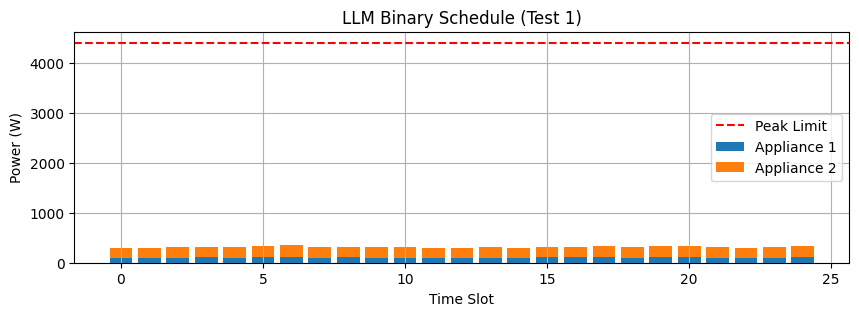

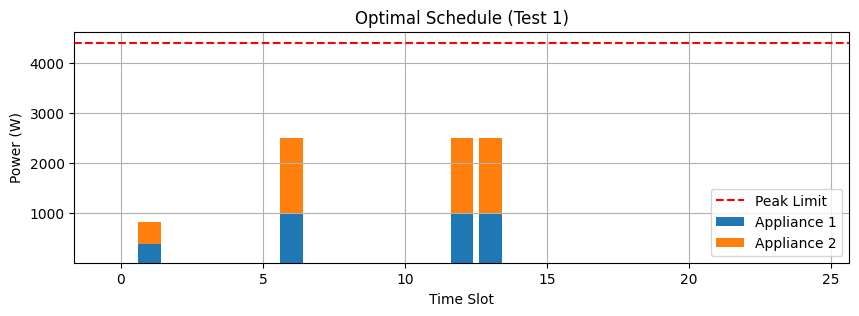

Test 1: Pred Cost=$0.97, Opt Cost=$0.47, Gap=$0.50



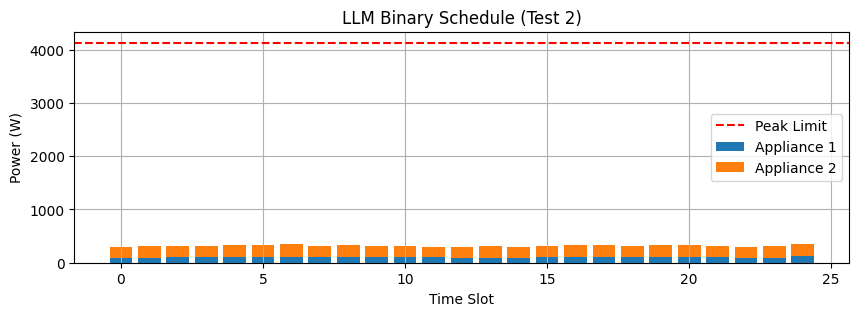

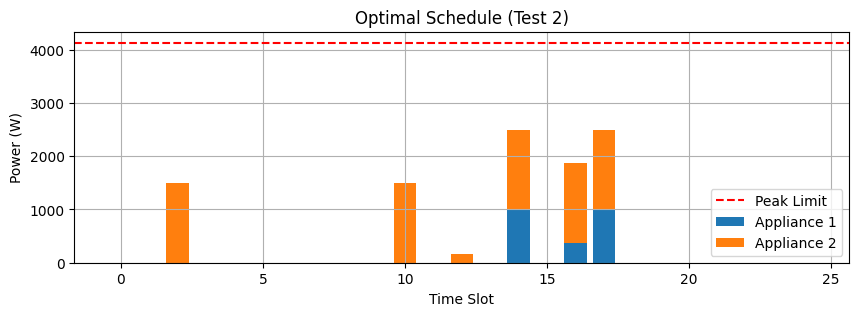

Test 2: Pred Cost=$0.95, Opt Cost=$0.63, Gap=$0.32



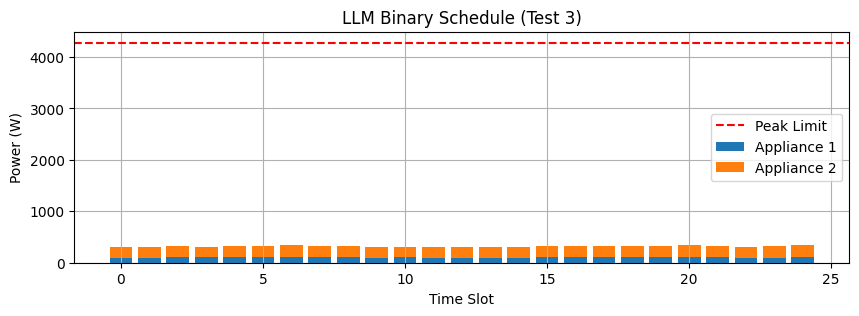

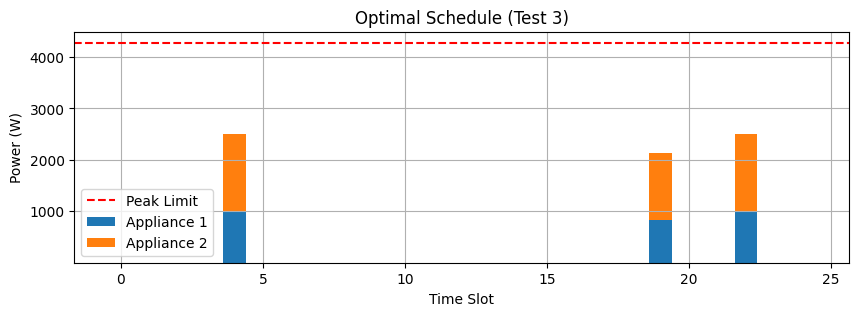

Test 3: Pred Cost=$1.11, Opt Cost=$0.42, Gap=$0.70



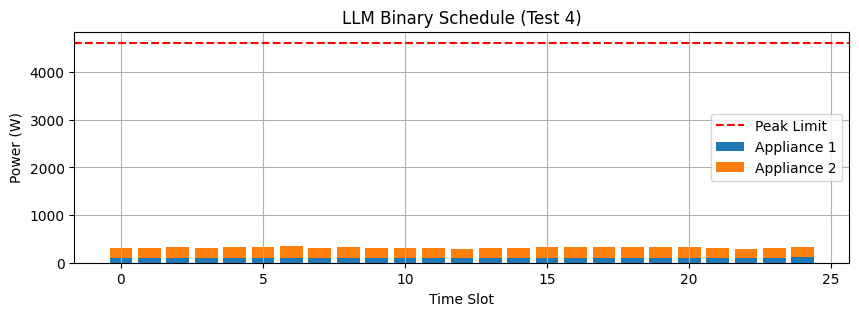

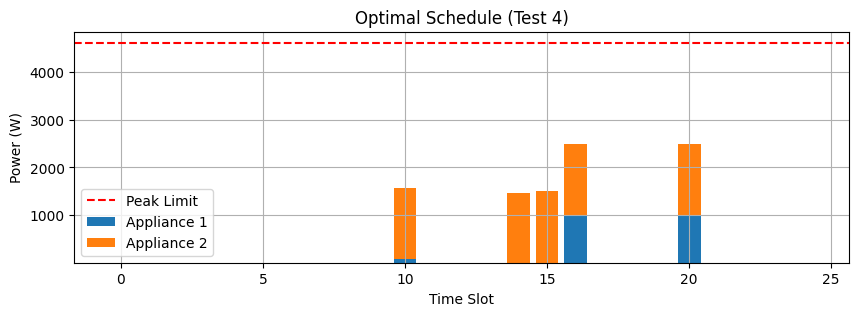

Test 4: Pred Cost=$0.93, Opt Cost=$0.55, Gap=$0.38



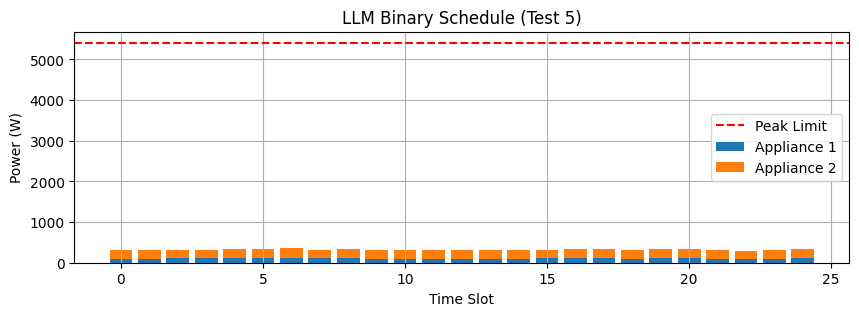

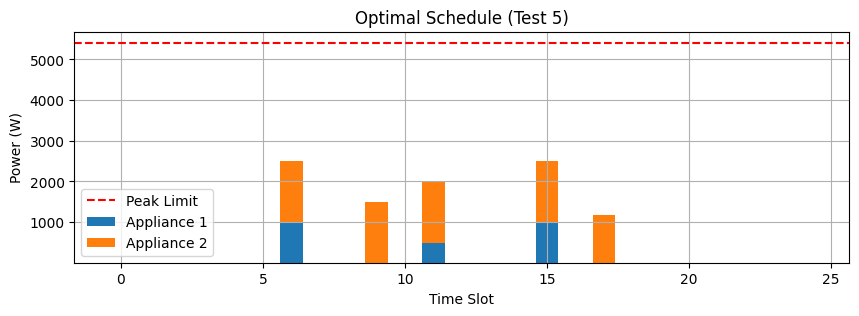

Test 5: Pred Cost=$0.95, Opt Cost=$0.59, Gap=$0.36



In [ ]:
############## No Fine-Tuning #################
import cvxpy as cp
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel
torch.cuda.empty_cache()

# 1) Convex oracle: solve the LP with default solver
def generate_optimal_schedule(price, P_h, E_h, peak_limit):
    N, H = len(price), len(P_h)
    X = cp.Variable((N, H))
    power = cp.multiply(X, P_h.reshape(1, H))
    cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
    constraints = [
        cp.sum(power, axis=0) >= E_h,
        cp.sum(power, axis=1) <= peak_limit,
        X >= 0, X <= 1
    ]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(verbose=False)
    # Round to 0/1
    return X.value.astype(float)

# 2) Structured Prompt Dataset
class TSLSupervisedDatasetStructured(Dataset):
    def __init__(self, n_samples, N, H):
        self.prompts = []
        self.targets = []
        self.N, self.H = N, H
        self.P_h = np.array([1000, 1500])  # Rated power for each appliance

        # Define ranges for energy requirements (in Wh)
        self.E_h_ranges = np.array([
            [2000, 4000],  # Appliance 1 range
            [4000, 8000]    # Appliance 2 range
        ])

        # Define the range for the peak limit (in Watts)
        self.peak_range = (2000, 6000)

        for _ in range(n_samples):
            price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
            # Sample energy requirements randomly from the defined ranges
            E_h = np.array([
                np.random.randint(self.E_h_ranges[0, 0], self.E_h_ranges[0, 1]),
                np.random.randint(self.E_h_ranges[1, 0], self.E_h_ranges[1, 1])
            ])
            # Sample a peak limit randomly from the given range for each sample
            peak_limit = np.random.randint(*self.peak_range)
            X_opt = generate_optimal_schedule(price, self.P_h, E_h, peak_limit)
            self.prompts.append(self._build_prompt(price, E_h, peak_limit))
            self.targets.append(torch.tensor(X_opt.flatten(), dtype=torch.float32))

    def _build_prompt(self, price, E_h, peak_limit):
        s = "[Prices]\n" + "\n".join(f"Slot {i+1}: {p:.3f} $/kWh" for i, p in enumerate(price))
        s += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(self.P_h, E_h), start=1):
            s += (f"Appliance {i}:\n"
                  f"  Rated Power: {pw/1000:.1f} kW\n"
                  f"  Energy Required: {eg/1000:.1f} kWh\n")
        s += f"\n[Peak Limit]\n{peak_limit/1000:.1f} kW\n"
        s += "\n[Objective]\nMinimize total electricity cost.\n"
        s += f"\n[Output]\nProvide a {self.N}x{self.H} schedule matrix."
        return s

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx], self.targets[idx]

# 3) Model: BERT-base → logits
class SupervisedTSLModel(nn.Module):
    def __init__(self, N, H):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        hidden = self.bert.config.hidden_size
        self.regressor = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Linear(hidden // 2, N * H)
        )

    def forward(self, prompts):
        enc = self.tokenizer(prompts,
                             padding=True,
                             truncation=True,
                             return_tensors="pt")
        device = next(self.bert.parameters()).device
        enc = {k: v.to(device) for k, v in enc.items()}
        out = self.bert(**enc).last_hidden_state[:, 0, :]  # CLS token representation
        return self.regressor(out)

# 4) Training with BCEWithLogitsLoss to get binary schedules
def train_model(model, dataset, epochs=20, batch_size=16, lr=2e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optim = AdamW(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    for ep in range(1, epochs + 1):
        model.train()
        running = 0.0
        for prompts, targets in loader:
            logits = model(prompts).to(device)
            loss = loss_fn(logits, targets.to(device))
            optim.zero_grad()
            loss.backward()
            optim.step()
            running += loss.item() * targets.size(0)
        print(f"Epoch {ep}/{epochs} — Avg Loss: {running/len(dataset):.6f}")
    return model

# 5) Test & plot just stacked bars (binary schedules)
def test_and_plot(model, tests=3, N=25):
    P_h = np.array([1000, 1500])
    # Define the same energy ranges as in training
    E_h_ranges = np.array([
        [2000, 4000],  # Appliance 1 range
        [4000, 8000]   # Appliance 2 range
    ])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model.eval().to(device)

    for t_i in range(1, tests + 1):
        price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
        # Sample energy requirements randomly for testing
        E_h = np.array([
            np.random.randint(E_h_ranges[0, 0], E_h_ranges[0, 1]),
            np.random.randint(E_h_ranges[1, 0], E_h_ranges[1, 1])
        ])
        # Sample a new peak limit from the defined range for testing
        peak = np.random.randint(2000, 6000)

        # Build the prompt using the randomized values
        p = "[Prices]\n" + "\n".join(f"Slot {i+1}: {v:.3f} $/kWh" for i, v in enumerate(price))
        p += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(P_h, E_h), start=1):
            p += (f"Appliance {i}:\n"
                  f"  Rated Power: {pw/1000:.1f} kW\n"
                  f"  Energy Required: {eg/1000:.1f} kWh\n")
        p += f"\n[Peak Limit]\n{peak/1000:.1f} kW\n"
        p += "\n[Objective]\nMinimize total electricity cost.\n"
        p += f"\n[Output]\nProvide a {N}x2 schedule matrix."

        # Predict using the model
        with torch.no_grad():
            enc = tokenizer([p], padding=True, truncation=True,
                            return_tensors="pt").to(device)
            out = model.bert(**enc).last_hidden_state[:, 0, :]
            logits = model.regressor(out)
            probs = torch.sigmoid(logits).cpu().numpy()[0].reshape(N, 2)
        bin_sched = probs.astype(float)

        # Get the optimal schedule for comparison
        opt_sched = generate_optimal_schedule(price, P_h, E_h, peak)

        # Plot predicted binary schedule
        t = np.arange(N)
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.bar(t, bin_sched[:, 0]*P_h[0], label="Appliance 1")
        ax.bar(t, bin_sched[:, 1]*P_h[1],
               bottom=bin_sched[:, 0]*P_h[0], label="Appliance 2")
        ax.axhline(peak, color='r', ls='--', label="Peak Limit")
        ax.set_title(f"LLM Binary Schedule (Test {t_i})")
        ax.set_xlabel("Time Slot")
        ax.set_ylabel("Power (W)")
        ax.legend(), ax.grid(True)
        plt.show()

        # Plot optimal schedule
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.bar(t, opt_sched[:, 0]*P_h[0], label="Appliance 1")
        ax.bar(t, opt_sched[:, 1]*P_h[1],
               bottom=opt_sched[:, 0]*P_h[0], label="Appliance 2")
        ax.axhline(peak, color='r', ls='--', label="Peak Limit")
        ax.set_title(f"Optimal Schedule (Test {t_i})")
        ax.set_xlabel("Time Slot")
        ax.set_ylabel("Power (W)")
        ax.legend(), ax.grid(True)
        plt.show()

        # Print cost summary
        cost_pred = (price[:, None] * (bin_sched * P_h)/1000.0).sum()
        cost_opt  = (price[:, None] * (opt_sched * P_h)/1000.0).sum()
        print(f"Test {t_i}: Pred Cost=${cost_pred:.2f}, Opt Cost=${cost_opt:.2f}, Gap=${cost_pred - cost_opt:.2f}\n")

# 6) Entry point
if __name__ == "__main__":
    torch.cuda.empty_cache()
    N, H = 25, 2

    # Create dataset
    ds = TSLSupervisedDatasetStructured(5000, N, H)

    # Initialize model
    model = SupervisedTSLModel(N, H)

    # ✅ Freeze all BERT parameters
    for param in model.bert.parameters():
        param.requires_grad = False

    # ✅ Print how many parameters will be trained
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params} (Only MLP head)\n")

    # Train only the MLP
    model = train_model(model, ds, epochs=30, batch_size=16, lr=2e-5)

    # Run test-time prediction and visualization
    test_and_plot(model, tests=5, N=N)
